<center><h1>F0-Detection Deep Neural Network</h1></center>

In [1]:
# Create network with Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import keras
import numpy 
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Using TensorFlow backend.


In [2]:
# Read all files in path and concatenate them (Is it a good pratice?)
path =r'../IAmelodyDNN' # use your path
allFiles = glob.glob(path + "/*features.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=None)
    list_.append(df)
frame = pd.concat(list_)

print(frame.shape)

(3242, 513)


In [3]:
df1=pd.read_csv("MusicDelta_Rockabilly_features.csv",header=None)
df2=pd.DataFrame.as_matrix(df1)
print (df2.shape)

df3=pd.read_csv("MusicDelta_Rockabilly_labels.csv",header=None)
df4=pd.DataFrame.as_matrix(df3)
df4 = df4[::2] # Hop size is doubled in features
print (df4.shape)

(1621, 513)
(1621, 1)


1621


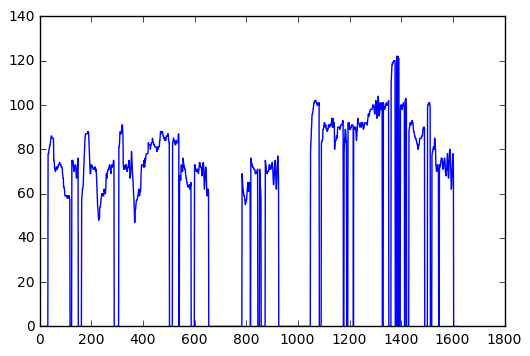

In [4]:
# Mais amostras
df5 = np.zeros(shape=(df2.shape[0],1))
df5[:df4.shape[0],:] = df4

print (df5.shape[0])
plt.plot(np.arange(len(df5)),df5)#, cmap=plt.get_cmap("Reds"))
plt.show()

# Test predictions from two DNNs
T = df2

(1621, 513) (1621, 1)
(1156, 513) (1156, 1)


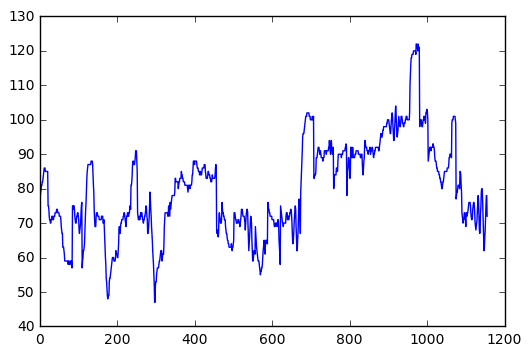

In [5]:
# Remove no vocal frames - train with only vocal frames
no_vocal = np.where(df5[:,0] < 1)
   
print (df2.shape, df5.shape)

for i in reversed(no_vocal):
    df2 = numpy.delete(df2, i, axis=0)
    df5 = numpy.delete(df5, i, axis=0)
    
print (df2.shape, df5.shape)

plt.plot(np.arange(len(df5)),df5)#, cmap=plt.get_cmap("Reds"))
plt.show()

In [6]:
## Train and test data
X = df2
Y = keras.utils.to_categorical(df5, num_classes=193)
x_test = np.random.random((100, 513))
y_test = keras.utils.to_categorical(np.random.normal(80, 20, size=(100, 1)), num_classes=193)

print (X.shape, Y.shape)

# create model
model = Sequential()
model.add(Dense(500, input_dim=513, activation='sigmoid'))
model.add(Dense(500, activation='sigmoid'))
model.add(Dense(193, activation='softmax'))

(1156, 513) (1156, 193)


In [7]:
print (X.shape, df2.shape)
print (Y.shape, df5.shape)

(1156, 513) (1156, 513)
(1156, 193) (1156, 1)


In [8]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# Fit the model
model.fit(X, Y, epochs=10, batch_size=10, validation_split=0.1, shuffle=True)

Train on 1040 samples, validate on 116 samples
Epoch 1/10
1040/1040 [==============================] - 4s - loss: 0.0265 - acc: 0.9948 - val_loss: 0.0258 - val_acc: 0.9948

In [10]:
# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

 960/1156 [=======================>......] - ETA: 0s 576/1156 [=============>................] - ETA: 0s
acc: 99.55%


In [11]:
# calculate predictions
predictions = model.predict(X)

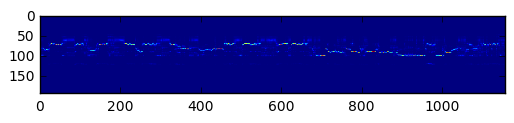

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the grid
plt.imshow(np.transpose(predictions))#,cmap=plt.get_cmap("Reds"))
plt.show()


## Viterbi tracking

Viterbi is used to smooth the path given by DNN results.
Not works well yet...

In [13]:
import numpy as np

tr_mtx = np.zeros((193,193))
for i in range(193):
    for j in range(193):
        tr_mtx[i,j] = 2**(-np.abs(int(i/8)-int(j/8)))

In [14]:
tr_mtx_normed = tr_mtx / tr_mtx.sum(axis=0)


In [15]:
import numpy as np

'''
N: number of hidden states
'''
class Decoder(object):
    def __init__(self, initialProb, transProb, obsProb):
        self.N = initialProb.shape[0]
        self.initialProb = initialProb
        self.transProb = transProb
        self.obsProb = obsProb
        assert self.initialProb.shape == (self.N, 1)
        assert self.transProb.shape == (self.N, self.N)
        assert self.obsProb.shape[0] == self.N

    def Obs(self, obs):
        return self.obsProb[:, obs, None]

    def Decode(self, obs):
        trellis = np.zeros((self.N, len(obs)))
        backpt = np.ones((self.N, len(obs)), 'int32') * -1

        # initialization
        trellis[:, 0] = np.squeeze(self.initialProb * self.Obs(obs[0]))

        for t in range(1, len(obs)):
            trellis[:, t] = (trellis[:, t-1, None].dot(self.Obs(obs[t]).T) * self.transProb).max(0)
            backpt[:, t] = (np.tile(trellis[:, t-1, None], [1, self.N]) * self.transProb).argmax(0)
        # termination
        tokens = [trellis[:, -1].argmax()]
        for i in range(len(obs)-1, 0, -1):
            tokens.append(backpt[tokens[-1], i])
        return tokens[::-1]

In [16]:
obs = np.argmax(np.transpose(predictions).tolist(), axis=0)
states = np.arange(193)
start_p = np.ones(193).reshape(193,1)
start_p = start_p/193
trans_p = tr_mtx_normed
emit_p = tr_mtx_normed

In [17]:
result = Decoder(start_p, trans_p, emit_p)
x = result.Decode(obs)

In [18]:
import scipy.signal
y = scipy.signal.medfilt(np.argmax(np.transpose(predictions), axis=0).tolist(), 5)

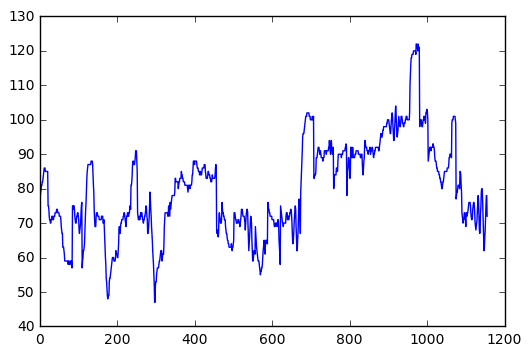

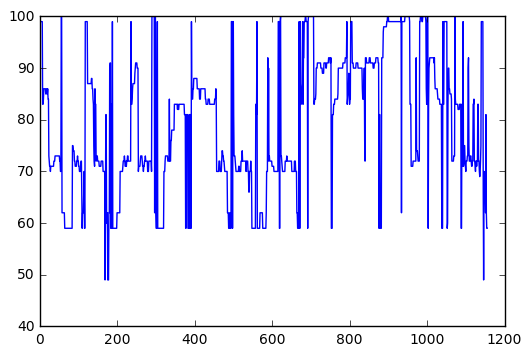

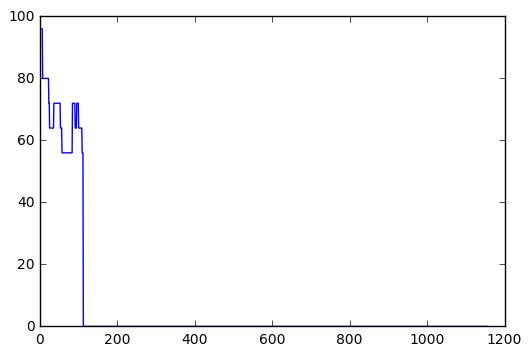

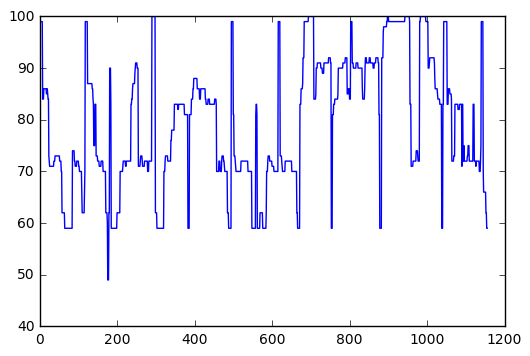

In [19]:
# Plot the grid

plt.plot(np.arange(len(df5)),df5)#, cmap=plt.get_cmap("Reds"))
plt.show()
pre = np.argmax(np.transpose(predictions), axis=0).tolist()
pre[pre==0] = None
plt.plot(np.arange(len(pre)),pre)#, cmap=plt.get_cmap("Reds"))
plt.show()
plt.plot(np.arange(len(x)),x)#, cmap=plt.get_cmap("Reds"))
plt.show()
plt.plot(np.arange(len(y)),y)#, cmap=plt.get_cmap("Reds"))
plt.show()

### Making prediction

In [52]:
# calculate predictions
predictions = model.predict(T)
# Remove noise
#import scipy.signal
x = scipy.signal.medfilt(np.argmax(np.transpose(predictions), axis=0).tolist(), 5)

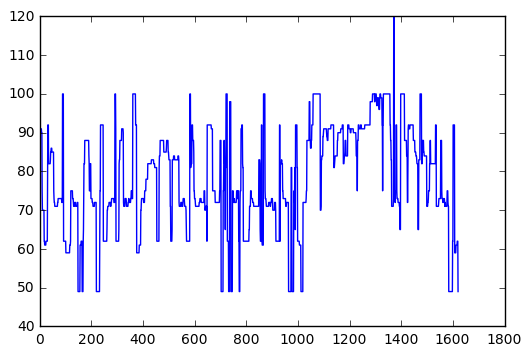

In [53]:
plt.plot(np.arange(len(x)),x)#, cmap=plt.get_cmap("Reds"))
plt.show()

### Saving results

In [54]:
# Write features file 
import csv
with open('F0result.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)

    spamwriter.writerow(x)

In [55]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Saved model to disk
Loaded model from disk
acc: 99.55%
